In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib.colors import SymLogNorm

from scipy import integrate
from scipy import stats

from tqdm import tqdm_notebook as tqdm 
import time

In [2]:
def display_mGU(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coalitions {}".format(out['k_']))
    
    plt.subplot(131)
    v_ = np.linspace(0,1,1001)
    
    for i in range(out['m']) :
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta_'][i],'b',label=r'$\delta_{}$'.format(i))
        plt.axhline(out['l_'][i],color='b',linestyle='--')
        
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    #plt.ylim((min(out['l2_star'],out['l1_star'])-0.1,max(out['l2_star'],out['l1_star'])+0.1))
    plt.title(r"Approximated functions : $\delta_i(t) = \lambda_i(t)/t$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    
    for i in range(out['m']) :
        plt.plot(b_,out['values_'][i],'b',label=r'$\lambda_{}$'.format(i))
        plt.plot(b_,out['l_'][i]*b_,'b--')
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)    
    for i in range(out['m']) :
        plt.plot(v_,[bid_f(v,i,out) for v in v_],'b',label=r"$\phi_{}$".format(i))
        plt.plot(v_,1/out['l_'][i]*v_,'b--')
        
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

### Shooting and Iterate methods

In [3]:
def shoot_mGU(tstar,k_,N=10_000,correct=True) : 
    k_ = np.array(k_)
    m = len(k_)
    
    if(np.any(k_==0)) :
        print("Given coalition sizes",k_)
        print("\terror every coalition size should be != 0")
        return

    delta_ = np.zeros((m,N+2))
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    output = {}
    output['m'] = m
    output['tstar'] = tstar
    output['N'] = N
    output['breakpoint'] = 0
    output['l_'] = l_
    output['k_'] = k_
    
    A_inv = 1/(m-1)*((np.ones((m,m))-np.eye(m))-(m-2)*np.eye(m))
    
    eps_f = lambda i : np.linalg.norm(delta_[:,i]-l_,2)
    
    delta_[:,N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
        tjm1 = tstar*(j-1)/(N+1)
        
        #A = np.ones((m,m))-np.eye(m)
        #y = np.array([ 1/(delta_[i,j]-1) - (np.sum(k_)-k_[i]) for i in range(m)])
        #x = np.linalg.solve(A,y)
        #delta_p_[:,j] = delta_[:,j]/(tj*k_)*x
        
        y = 1/(delta_[:,j]-1) - (np.sum(k_)-k_)
        x = A_inv@y
        
        #deltap_j_ = delta_[:,j]/(tj*k_)*x
        #delta_[:,j-1] = delta_[:,j]+(tjm1-tj)*deltap_j_
        
        delta_[:,j-1] = delta_[:,j]*(1-x/(j*k_))
        
        if(output['breakpoint'] == 0 and eps_f(j-1) > eps_f(j) ) :
            output['breakpoint'] = j
            if(correct) :
                break

    output['eps_star'] = eps_f(output['breakpoint'])
    if(correct) :
        ind = output['breakpoint']
        for i in range(m) :
            delta_[i,:ind+1] = np.linspace(l_[i],delta_[i,ind],ind+1)
        
    output['delta_'] = delta_
    output['values_'] = np.zeros_like(delta_)
    output['values_'] = np.linspace(0,tstar,N+2)*delta_
        
    return output

In [4]:
def iterate_mGU(k_,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    if(np.any(k_==0)) :
        print("Every coalition size should be != 0")
        return
    
    k_ = np.array(k_)
    m = len(k_)
    
    l_ = 1+1/(np.sum(k_)-k_)
    
    a = 1/np.max(l_)
    b = 1/np.min(l_)
                 
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
    
    x_2 = a + tau*(b-a)
    f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = shoot_mGU(x_2,k_,N=N,correct=correct)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = shoot_mGU(x_1,k_,N=N,correct=correct)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(f_1['eps_star']<f_2['eps_star']) :
            print("tstar :",f_1['tstar'])
        else :
            print("tstar :",f_2['tstar'])
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
            
    if(f_1['eps_star']<f_2['eps_star']) :
        if(display_graphs) :
            display_mGU(f_1)
        return f_1
    else :
        if(display_graphs) :
            display_mGU(f_2)
        return f_2

In [5]:
def scenario_mGU(alpha_,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    
    m = len(alpha_)
    k_ = [np.sum(alpha_[i])  for i in range(m)]
    
    out = iterate_mGU(k_,eps=eps,nb_eval_max=nb_eval_max,N=N,show_msg=show_msg,display_graphs=display_graphs,correct=correct)
    
    b_ = np.linspace(0,out['tstar'],N+2)
    
    def integrand_coal(i,v) :
        res = v-bid_f(v,i,out)
        phi_i_v = bid_f(v,i,out)
        for j in range(m) :
            if(j!=i) :
                res *= value_f(phi_i_v,j,out)**k_[j]
        res *= k_[i]*v**(k_[i]-1)
        return res
    
    res = {'coal_':[] , 'coal__':[]}
    
    for i in range(m) :
        integrand = lambda v : integrand_coal(i,v)
        res['coal_'].append( integrate.quad(integrand, 0, 1, limit=10_000, epsabs=10**-15,epsrel=10**-15)[0] )
        res['coal__'].append( np.array(alpha_[i])/k_[i]*res['coal_'][i] )
    
    return res

----

# <center>Numerical experiments</center>

In [6]:
def value_f(b,i,shoot_output) :
    return np.interp(b,np.linspace(0,shoot_output['tstar'],shoot_output['N']+2),shoot_output['values_'][i])

def bid_f(v,i,shoot_output) :
    return np.interp(v,shoot_output['values_'][i],np.linspace(0,shoot_output['tstar'],shoot_output['N']+2))

In [7]:
def utility_0_f(v,k,o) :
    return (v-bid_f(v,0,o)) * v**(strength_in*(k-1)) * value_f(bid_f(v,0,o),1,o)**(strength_out*(n-k))

def utility_1_f(v,k,o) :
    return (v-bid_f(v,1,o)) * value_f(bid_f(v,1,o),0,o)**(strength_in*k) * v**(strength_out*(n-k-1))

#def utility_c_f(v,o) :
#    return (v-bid_f(v,0,o)) * value_f(bid_f(v,0,o),1,o)**(n-o['k_'][0]/strength)

def proba_0_f(v,k,o) :
    return v**(strength_in*(k-1)) * value_f(bid_f(v,0,o),1,o)**(strength_out*(n-k))

def proba_1_f(v,k,o) :
    return value_f(bid_f(v,1,o),0,o)**(strength_in*k) * v**(strength_out*(n-k-1))

---

In [8]:
n=5; k=4
strength=1; strength_in=1; strength_out=1
out_5 = iterate_mGU([strength_in*k]+[strength_out]*(n-k),eps=10**-7)

n=10; k=8
strength=1/20; strength_in=1/20; strength_out=1/20
out_10 = iterate_mGU([strength_in*k]+[strength_out]*(n-k),eps=10**-7)

In [52]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size" : 18
})

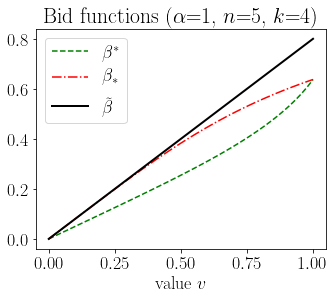

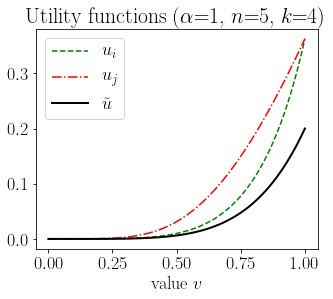

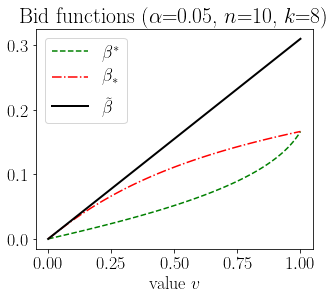

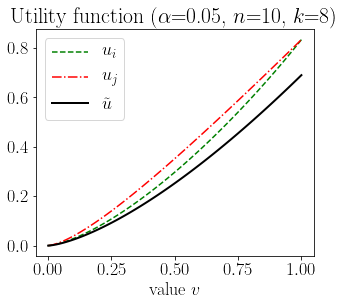

In [67]:
v_ = np.linspace(0,1,100)

n=5; k=4
strength=1; strength_in=1; strength_out=1

width=5
ratio=0.9
plt.figure(figsize=(width,width*ratio))
plt.plot(v_,[bid_f(v,0,out_5) for v in v_],'g--',label=r"$\beta^*$")
plt.plot(v_,[bid_f(v,1,out_5) for v in v_],'r-.',label=r"$\beta_*$")
plt.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
plt.title(r"Bid functions ($\alpha$={}, $n$={}, $k$={})".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.tight_layout()
plt.savefig("bid_graph_1.png")
plt.show()


plt.figure(figsize=(width,width*ratio))
plt.plot(v_,[utility_0_f(v,k,out_5) for v in v_],'g--',label=r"$u_i$")
plt.plot(v_,[utility_1_f(v,k,out_5) for v in v_],'r-.',label=r"$u_j$")
plt.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
plt.title(r"Utility functions ($\alpha$={}, $n$={}, $k$={})".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.tight_layout()
plt.savefig("utility_graph_1.png")
plt.show()

n=10; k=8
strength=1/20; strength_in=1/20; strength_out=1/20

plt.figure(figsize=(width,width*ratio))
plt.plot(v_,[bid_f(v,0,out_10) for v in v_],'g--',label=r"$\beta^*$")
plt.plot(v_,[bid_f(v,1,out_10) for v in v_],'r-.',label=r"$\beta_*$")
plt.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
plt.title(r"Bid functions ($\alpha$={}, $n$={}, $k$={})".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.tight_layout()
plt.savefig("bid_graph_2.png")
plt.show()

plt.figure(figsize=(width+.1,(width+.1)*ratio))
plt.plot(v_,[utility_0_f(v,k,out_10) for v in v_],'g--',label=r"$u_i$")
plt.plot(v_,[utility_1_f(v,k,out_10) for v in v_],'r-.',label=r"$u_j$")
plt.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
plt.title(r"Utility function ($\alpha$={}, $n$={}, $k$={})".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.tight_layout()
plt.savefig("utility_graph_2.png")
plt.show()

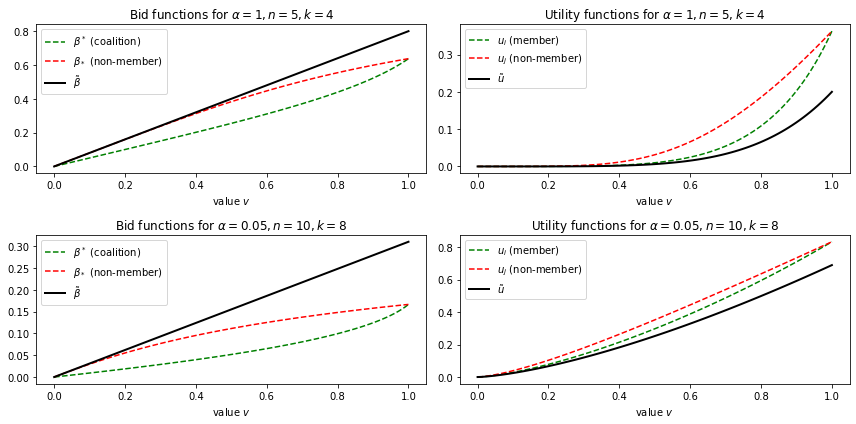

In [12]:
v_ = np.linspace(0,1,100)

n=5; k=4
strength=1; strength_in=1; strength_out=1

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_size_inches(6*2,3*2)
#fig = plt.figure(figsize=(6*2,4*2))

ax1.plot(v_,[bid_f(v,0,out_5) for v in v_],'g--',label=r"$\beta^*$ (coalition)")
ax1.plot(v_,[bid_f(v,1,out_5) for v in v_],'r--',label=r"$\beta_*$ (non-member)")
ax1.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
ax1.set_title(r"Bid functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
ax1.legend()
ax1.set_xlabel(r"value $v$")

ax2.plot(v_,[utility_0_f(v,k,out_5) for v in v_],'g--',label=r"$u_i$ (member)")
ax2.plot(v_,[utility_1_f(v,k,out_5) for v in v_],'r--',label=r"$u_j$ (non-member)")
ax2.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
ax2.set_title(r"Utility functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
ax2.legend()
ax2.set_xlabel(r"value $v$")

n=10; k=8
strength=1/20; strength_in=1/20; strength_out=1/20

ax3.plot(v_,[bid_f(v,0,out_10) for v in v_],'g--',label=r"$\beta^*$ (coalition)")
ax3.plot(v_,[bid_f(v,1,out_10) for v in v_],'r--',label=r"$\beta_*$ (non-member)")
ax3.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
ax3.set_title(r"Bid functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
ax3.legend()
ax3.set_xlabel(r"value $v$")

ax4.plot(v_,[utility_0_f(v,k,out_10) for v in v_],'g--',label=r"$u_i$ (member)")
ax4.plot(v_,[utility_1_f(v,k,out_10) for v in v_],'r--',label=r"$u_j$ (non-member)")
ax4.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
ax4.set_title(r"Utility functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
ax4.legend()
ax4.set_xlabel(r"value $v$")

plt.tight_layout()
plt.savefig("graphs.png")
plt.show()

In [8]:
n = 10
k_ = np.arange(1,n)
strength = 1#/20
strength_in = strength#9#1/20
strength_out = strength

out_ = {}
for k in tqdm(k_) :
    setup_ = [strength_in*k]+[strength_out]*(n-k)
    out_[k] = iterate_mGU(setup_,eps=10**-7)

In [9]:
n = 5
k_ = np.arange(1,n)
strength = 1#/20
strength_in = strength#9#1/20
strength_out = strength

out_1 = {}
for k in tqdm(k_) :
    setup_ = [strength_in*k]+[strength_out]*(n-k)
    out_1[k] = iterate_mGU(setup_,eps=10**-7)

v_ = np.linspace(0,1,100)
k = 4

plt.figure(figsize=(6,3))
o = out_1[k]
plt.plot(v_,[bid_f(v,0,o) for v in v_],'g--',label=r"$\beta^*$ (coalition)")
plt.plot(v_,[bid_f(v,1,o) for v in v_],'r--',label=r"$\beta_*$ (non-member)")
plt.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
#plt.plot([bid_f(v,1,out_1[1]) for v in v_],v_, 'r--',label=r"$\tilde{\beta}$")
plt.title(r"Bid functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.savefig("bid_graphs_small_1.png")
plt.show()

plt.figure(figsize=(6,3))
o = out_1[k]
plt.plot(v_,[utility_0_f(v,k,o) for v in v_],'g--',label=r"$u_i$ (member)")
plt.plot(v_,[utility_1_f(v,k,o) for v in v_],'r--',label=r"$u_j$ (non-member)")
plt.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
#plt.plot(v_,[utility_1_f(v,1,out_1[1]) for v in v_], 'k+',label=r"$\tilde{\beta}$")
plt.title(r"Utility functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.savefig("utility_graphs_small_1.png")
plt.show()

KeyboardInterrupt: 

In [ ]:
n = 10
k_ = np.arange(1,n)
strength = 1/20
strength_in = strength#9#1/20
strength_out = strength

out_ = {}
for k in tqdm(k_) :
    setup_ = [strength_in*k]+[strength_out]*(n-k)
    out_[k] = iterate_mGU(setup_,eps=10**-7)
    
v_ = np.linspace(0,1,100)
k = 8

plt.figure(figsize=(6,3))
o = out_[k]
plt.plot(v_,[bid_f(v,0,o) for v in v_],'g--',label=r"$\beta^*$ (coalition)")
plt.plot(v_,[bid_f(v,1,o) for v in v_],'r--',label=r"$\beta_*$ (non-member)")
plt.plot(v_,v_*1/(1+1/(strength*(n-1))),'k-',linewidth=2,label=r"$\tilde{\beta}$")
#plt.plot([bid_f(v,1,out_[1]) for v in v_],v_, 'r--',label=r"$\tilde{\beta}$")
plt.title(r"Bid functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.savefig("bid_graphs_small_2.png")
plt.show()

plt.figure(figsize=(6,3))
o = out_[k]
plt.plot(v_,[utility_0_f(v,k,o) for v in v_],'g--',label=r"$u_i$ (member)")
plt.plot(v_,[utility_1_f(v,k,o) for v in v_],'r--',label=r"$u_j$ (non-member)")
plt.plot(v_,v_**(strength*(n-1)+1)/(strength*(n-1)+1),'k-',linewidth=2,label=r"$\tilde{u}$")
#plt.plot(v_,[utility_1_f(v,1,out_[1]) for v in v_], 'k+',label=r"$\tilde{\beta}$")
plt.title(r"Utility functions for $\alpha={}, n={}, k={}$".format(strength,n,k))
plt.legend()
plt.xlabel(r"value $v$")
plt.savefig("utility_graphs_small_2.png")
plt.show()

---

-----

 $$ \large \underbrace{F^{n-k}(v_{out}(\beta_{in}(v))) F^{k-1}(v)}_{P_{in}} \leq F^{n-1}(v) \leq \underbrace{F^{k}(v_{in}(\beta_{out}(v))) F^{n-k-1}(v) }_{P_{out}}$$

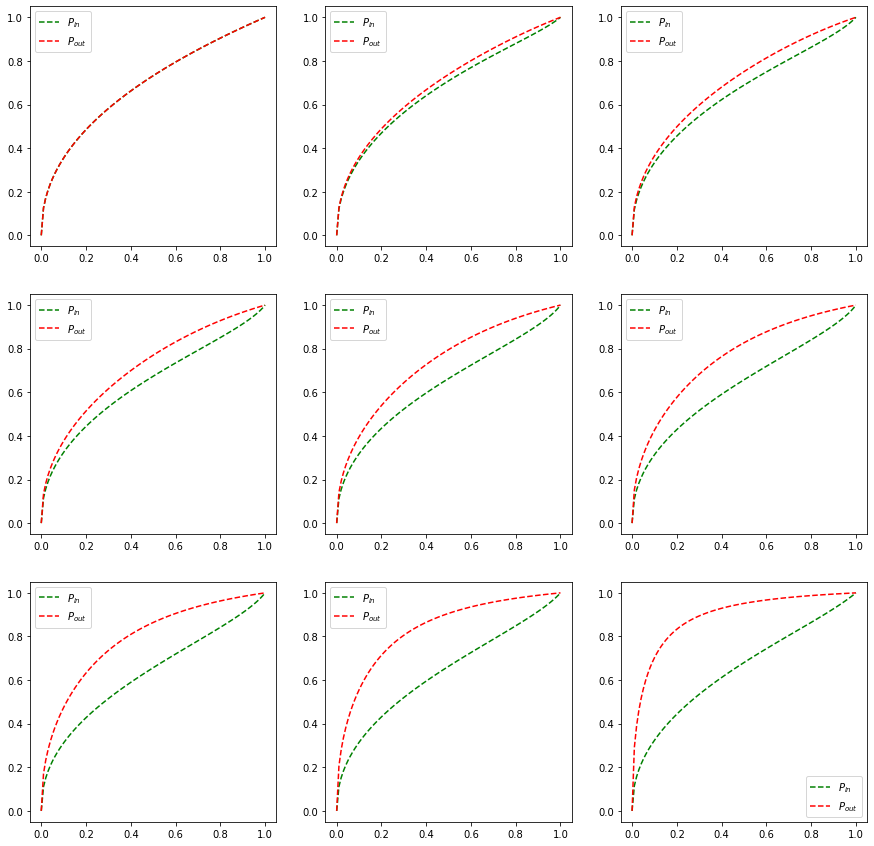

In [13]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,15))

for k in k_ :
    plt.subplot(3,3,k)
    
    #plt.plot(v_,[proba_0_f(v,1,out_[1]) for v in v_],'k',label=r'baseline')
    plt.plot(v_,[proba_0_f(v,k,out_[k]) for v in v_],'g--',label=r'$P_{in}$')
    plt.plot(v_,[proba_1_f(v,k,out_[k]) for v in v_],'r--',label=r'$P_{out}$')
    plt.legend()
    
plt.show()

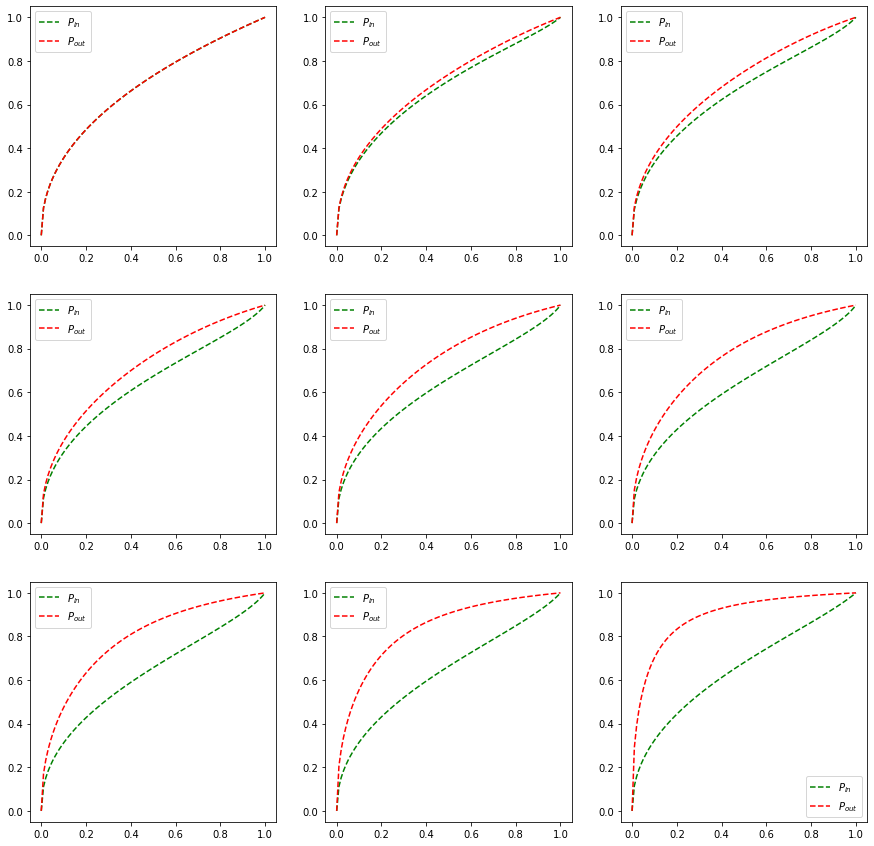

In [14]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,15))

for k in k_ :
    plt.subplot(3,3,k)
    
    #plt.plot(v_,[proba_0_f(v,1,out_[1]) for v in v_],'k',label=r'baseline')
    plt.plot(v_,[proba_0_f(v,k,out_[k]) for v in v_],'g--',label=r'$P_{in}$')
    plt.plot(v_,[proba_1_f(v,k,out_[k]) for v in v_],'r--',label=r'$P_{out}$')
    plt.legend()
    
plt.show()

---

NameError: name 'out' is not defined

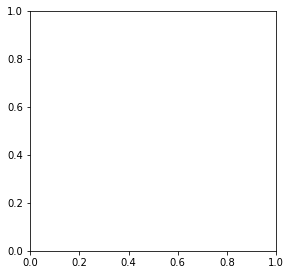

In [15]:
plt.figure(figsize=(15,15))

for i in range(len(k_)) :
    plt.subplot(3,3,i+1)
    
    k = k_[i]
    o = out[i]
    b_ = np.linspace(0,o['tstar'],1000)
        
    plt.plot(b_,[value_f(b,0,o)**(strength*k) for b in b_ ],label='ring bid cdf')
    plt.plot(b_,[value_f(b,1,o)**(strength) for b in b_ ],label='external indivudal bid cdf')
    plt.legend()
    
plt.show()

----

In [ ]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,15))

for i in range(len(k_)) :
    plt.subplot(3,3,i+1)
    k = k_[i]
    o = out[i]
    #plt.plot(v_[-20:],[v**(strength*(n-1)+1)/(strength*(n-k)+1) for v in v_[-20:] ],color='gray',label='ub')
    #plt.plot(v_[-20:],[v**(strength*(k-1)+strength*k*(n-k)+1)/(strength*k*(n-k)+1) for v in v_[-20:] ],color='gray',label='lb')
    
    #plt.plot(v_[-20:],[v**(strength*(k*((n-k+1)/(n-k))-1)+1)/(strength*(k*((n-k+1)/(n-k))-1)+1) for v in v_[-20:] ],color='red',label='new bound')
    
    plt.plot(v_,[k*v**(strength*(n-1)+1)/(strength*(n-1)+1) for v in v_ ],'k',label=r'$\int^v F^{n-1}$')
    plt.plot(v_,[k*utility_0_f(v,o) for v in v_],'g--',label='U_in')
    plt.legend()
    
plt.show()

$$ \large \int_{\underline{c}}^v F^{n-1}(w)dw \leq U_{in}(v) \leq U_{out}(v) $$

In [ ]:
v_ = np.linspace(0,1,1000)

i=0
plt.figure(figsize=(16,10))
for a in np.linspace(0.1,0.9,11)/(1-np.linspace(0.1,0.9,11)) :
    i+=1
    plt.subplot(4,3,i)
    plt.title(a)
    plt.plot(v_,stats.beta(a=a,b=1).pdf(v_))
    plt.axhline(a,color='k')
plt.show()

In [ ]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,15))

for i in range(len(k_)) :
    plt.subplot(3,3,i+1)
    k = k_[i]
    o = out[i]
    #plt.plot(v_[-20:],[v**(strength*(n-1)+1)/(strength*(n-k)+1) for v in v_[-20:] ],color='gray',label='ub')
    #plt.plot(v_[-20:],[v**(strength*(k-1)+strength*k*(n-k)+1)/(strength*k*(n-k)+1) for v in v_[-20:] ],color='gray',label='lb')
    
    #plt.plot(v_[-20:],[v**(strength*(k*((n-k+1)/(n-k))-1)+1)/(strength*(k*((n-k+1)/(n-k))-1)+1) for v in v_[-20:] ],color='red',label='new bound')
    
    plt.plot(v_,[v**(strength*(n-1)+1)/(strength*(n-1)+1) for v in v_ ],'k',label=r'$\int^v F^{n-1}$')
    plt.plot(v_,[utility_0_f(v,o) for v in v_],'g--',label='U_in')
    plt.plot(v_,[utility_1_f(v,o) for v in v_],'r--',label='U_out')
    plt.legend()
    
plt.show()

----

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(k_)) :
    k = k_[i]
    o = out[i]
    b_ = np.linspace(0,o['tstar'],1000)
    plt.plot(b_, [value_f(b,0,o) for b in b_],'g')
    plt.plot(b_, [value_f(b,1,o) for b in b_],'r')
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
for i in [0] :
    k = k_[i]
    o = out[i]
    op = out[i+1]
    b_ = np.linspace(0,op['tstar'],1000)
    
    plt.plot(b_[-10:], [value_f(b,1,op) for b in b_[-10:]],'b')
    plt.plot(b_[-10:], [value_f(b,0,o) for b in b_[-10:]],'r')
    
    #plt.semilogy(b_, [((value_f(b,1,op))**(strength*(n-k-2))*(value_f(b,0,op))**(strength*(k+1)))/((value_f(b,1,o))**(strength*(n-k-1))*(value_f(b,0,o))**(strength*(k))) for b in b_])
    #plt.semilogy(b_, [((value_f(b,1,op))**(strength*(n-k-1)))/((value_f(b,1,o))**(strength*(n-k))) for b in b_])
    
    plt.axhline(1,color='k')
plt.show()

-----

$$ \large \beta^{n-1}_{in} \leq\dots \leq \beta_{in}^k \leq \beta_{in}^{k-1} \leq \dots \leq \beta^1_{in}  =\beta^1_{out}$$ 
$$ \large \beta^{n-1}_{out} \leq\dots \leq \beta_{out}^k \leq \beta_{out}^{k-1} \leq \dots \leq \beta^1_{out} = \beta^1_{in} $$

In [ ]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(14,8))
for i in range(len(k_)) :
    if(i==7) : 
        k = k_[i]
        o = out[i]
        plt.plot([bid_f(v,0,o) for v in v_],v_,'g',label=r"$\beta^k_{in}$")
        plt.plot([bid_f(v,1,o) for v in v_],v_, 'r',label=r"$\beta^k_{out}$")
        plt.plot(v_*(1-1/(strength*(n-1)+1)),v_,'rx',linewidth=2,label=r"$\beta^1$")
        plt.plot(v_*1/(1+1/(strength*(n-1))),v_,'k+',linewidth=2,label=r"$\beta^1$")
        plt.plot(v_*(1-1/(strength*(n-k)+1)),v_,'gx',linewidth=2,label=r"$\beta^k$")
plt.legend()
plt.show()

----

$$ \large U^1_{out}(v) = U^1_{in}(v) \leq\dots \leq U^k_{in}(v) \leq U^{k+1}_{in}(v)$$

$$ \large U^1_{in}(v) = U^1_{out}(v) \leq\dots \leq U^k_{out}(v) \leq U^{k+1}_{out}(v)$$

In [ ]:
plt.figure(figsize=(15,17))

plt.subplot(2,1,1)
for i in [3] :
    k = k_[i]
    o = out[i]
    b_ = np.linspace(0,o['tstar'],1000)
    
    print(strength)
    print(n)
    print(k)
    print(o['tstar'])
    
    plt.plot(b_,[(value_f(b,0,o))**(strength*(n-k))-(value_f(b,1,o))**(strength*(n-k)) for b in b_])
    plt.plot(b_,[((k-1)*stats.beta(a=strength,b=1).pdf(value_f(b,0,o))/(value_f(b,0,o)**strength))*(value_f(b,0,o)-b)*(value_f(b,1,o)**(strength*(n-k))) for b in b_])
    
    #plt.plot(v_, [utility_0_f(v,o) for v in v_],label=str(k))
    #plt.plot(v_[-10:],(1+(k-1)* 0.01 *utility_0_f(1,o))*(v_[-10:])+(utility_0_f(1,o)-(1+(k-1)* 0.01 *utility_0_f(1,o))),'--')
    #plt.legend()

In [ ]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,17))

plt.subplot(2,1,1)
for i in range(len(k_)) :
    k = k_[i]
    o = out[i]
    plt.plot(v_, [utility_0_f(v,o) for v in v_],label=str(k))
    plt.plot(v_[-10:],(1+(k-1)* 0.01 *utility_0_f(1,o))*(v_[-10:])+(utility_0_f(1,o)-(1+(k-1)* 0.01 *utility_0_f(1,o))),'--')
    plt.legend()
    
plt.subplot(2,1,2)
for i in range(len(k_)) :
    k = k_[i]
    o = out[i]
    plt.plot(v_, [utility_1_f(v,o) for v in v_],label=str(k))
    plt.plot(v_[-10:],v_[-10:]+utility_1_f(1,o)-1,'--')
    plt.legend()
plt.show()

----

$$kU^{k}_{in}(v)  > (k-1)U^{k-1}_{in}(v) + U^{k-1}_{out}(v)$$

In [ ]:
v_ = np.linspace(0,1,100)

plt.figure(figsize=(15,15))

for i in range(1,len(k_)) :
    plt.subplot(3,3,i+1)
    k = k_[i]
    plt.plot(v_,[k*utility_0_f(v,out[i]) for v in v_],'g--',label=r'$kU^{k}_{in}$')
    plt.plot(v_,[(k-1)*utility_0_f(v,out[i-1])+utility_1_f(v,out[i-1]) for v in v_],'r--',label=r'$(k-1)U^{k-1}_{in}+U^{k-1}_{out}$')
    
    plt.legend()
    
plt.show()

----

### Defection tests

In [ ]:
n = 100
k_ = np.arange(1,n)

values_ = np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)

In [ ]:
n = 10
k_ = np.arange(1,n)

values_ = np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)

In [ ]:
n = 10
k_ = np.arange(1,n)

values_ = 0.9/(1-0.9)*np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)

In [ ]:
n = 10
k_ = np.arange(1,n)

values_ = 0.1/(1-0.1)*np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)

In [ ]:
n = 100
k_ = np.arange(1,n)

values_ = 0.1/(1-0.1)*np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)
    if(res[-2]['coal__'][0][0]-res[-3]['coal__'][1][0]<0) :
        break

In [ ]:
n = 20
k_ = np.arange(1,n)

values_ = np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)
    if(k>2 and res[-2]['coal__'][0][0]-res[-3]['coal__'][1][0]<0) :
        break

In [ ]:
n = 20
k_ = np.arange(1,n)

values_ = 0.1/(1-0.1)*np.ones(n)

res = []
for k in k_ :
    setup_ = [[values_[i] for i in range(k)]]+[[values_[i]] for i in range(k,n)]
    
    res.append(scenario_mGU(setup_,eps=10**-7))
    
    if(k>1) :
        print(k,res[-1]['coal__'][0][0]-res[-2]['coal__'][1][0]>=0)
    if(k>2 and res[-2]['coal__'][0][0]-res[-3]['coal__'][1][0]<0) :
        break